### `---------------Mandatory Information to fill------------`

### Group ID:
### Group Members Name with Student ID:
1. Student 1
2. Student 2
3. Student 3
4. Student 4


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

# Background

A large e-commerce organization operates a homepage recommendation slot that displays one product to each visiting user. The company aims to maximize long-term net profit from these recommendations.

You are provided with a dataset of **498 user sessions**, each representing how a particular user would respond to each of six products.

Link for accessing dataset:
https://drive.google.com/file/d/14yDuW-zFs9-fh6ySH9xmULFcZuKVhn1r/view?usp=sharing


The dataset structure is:

*UserID, Product1, cost1, Product2, cost2, … , Product6, cost6*


Each row corresponds to one user and contains the following information.

## Product X column
The value under **Product X** represents the actual revenue the system would earn from that specific user if Product X were shown.

Revenue varies across users because:

- different users purchase different quantities  
- some users click while others ignore  
- some users spend more  
- some users purchase premium items or bundles  

Thus, actual revenue is **user-dependent**, not product-dependent.  
The same product may generate high revenue from one user and very low revenue from another.

## Cost X column
The value under **cost X** represents the personalized promotional cost incurred to show Product X to that user. This may include:

- dynamic advertisement bidding cost (CPC)  
- discounts or coupon values offered  
- targeted promotion cost  
- personalization overhead  

Costs differ across users because:

- some users require higher incentive levels  
- some are expensive to target via ads  
- some convert easily with minimal cost  

Thus, cost is also **user-dependent** and varies per session.



# Environment Dynamics

## Arms
In the Multi-Armed Bandit formulation:

There are **6 arms**:
A = {1, 2, 3, 4, 5, 6}

Arm X corresponds to recommending **Product X**.

## Reward
For each product X and each user session i:

$
\text{NetReward}_{i,X} = \text{Product}_{i,X} - \text{Cost}_{i,X}
$

This net reward represents the **profit** gained from showing product X to user i.  
This is the metric the organization aims to maximize.


# Current Organizational Policy

The organization currently follows a **random recommendation policy**:

“For each user visit, randomly select one of the six products and display it.”

This strategy:

- does not learn from previous outcomes  
- does not identify which products consistently deliver higher profit  
- wastes impressions on low-value products  
- provides unstable and suboptimal profit performance  

Management asks you to investigate:

- Whether a learning-based approach can yield better decisions  
- Which products are actually profitable when user variability is considered  
- How alternative strategies compare to the random policy  



# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario.

### Initialize constants

In [1]:

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)


# Design a Product Environment with Reward calculation (1M)

In [2]:

# Load dataset
df = pd.read_csv("Dataset_Product_Recommendation.csv")

# Normalize column names: remove spaces, lowercase
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "")
    .str.lower()
)

print(df.columns)


# Compute Net Reward for each product
for i in range(1, 7):
    df[f'netreward_{i}'] = df[f'product{i}'] - df[f'cost{i}']


df.head()


Index(['user_id', 'product1', 'cost1', 'product2', 'cost2', 'product3',
       'cost3', 'product4', 'cost4', 'product5', 'cost5', 'product6', 'cost6'],
      dtype='object')


,user_id,product1,cost1,product2,cost2,product3,cost3,product4,cost4,product5,cost5,product6,cost6,netreward_1,netreward_2,netreward_3,netreward_4,netreward_5,netreward_6
0,1,8.308075,0.118582,71.868439,4.032662,41.858863,10.259441,24.726454,15.071291,2.508992,19.966871,60.703456,22.545958,8.189493,67.835777,31.599422,9.655163,-17.457879,38.157498
1,2,9.040232,1.276014,71.551909,4.893586,40.684587,9.183102,23.554125,14.188975,2.803275,19.766006,59.838882,22.771789,7.764218,66.658323,31.501485,9.365150,-16.962731,37.067093
2,3,8.405164,2.573752,72.221606,5.201210,43.586272,10.972955,24.572589,14.177388,3.028663,20.104219,58.512739,22.247714,5.831412,67.020396,32.613317,10.395201,-17.075556,36.265025
3,4,9.247704,1.375703,71.218781,4.120079,40.883604,10.480112,24.572818,15.133472,3.193420,20.347757,58.694852,22.659512,7.872001,67.098702,30.403492,9.439346,-17.154337,36.035340
4,5,9.144098,-0.401791,71.275463,5.032439,40.145258,10.448089,23.401485,16.027929,3.466858,19.476062,59.009021,23.302446,9.545889,66.243024,29.697169,7.373556,-16.009204,35.706575


#Implement the existing Strategy 1 (1M)



In [3]:

def run_random_policy(df, rounds=300):
    rewards = []
    for _ in range(rounds):
        user = df.sample(1).iloc[0]
        arm = random.randint(1, 6)
        rewards.append(user[f'netreward_{arm}'])
    return np.cumsum(rewards)

random_rewards = run_random_policy(df, 300)
np.mean(np.diff(np.insert(random_rewards, 0, 0)))


np.float64(23.991233529333332)

# Strategy 2 (0.5 M)
Instead of picking randomly, try each product a few times, measure the average profit, and then always select the best-performing one.

In [4]:

def greedy_policy(df, warmup=10, rounds=300):
    counts = np.zeros(6)
    values = np.zeros(6)
    rewards = []

    # Warm-up
    for arm in range(6):
        for _ in range(warmup):
            user = df.sample(1).iloc[0]
            r = user[f'netreward_{arm+1}']
            counts[arm] += 1
            values[arm] += r
            rewards.append(r)

    for _ in range(rounds - 6 * warmup):
        arm = np.argmax(values / counts)
        user = df.sample(1).iloc[0]
        r = user[f'netreward_{arm+1}']
        counts[arm] += 1
        values[arm] += r
        rewards.append(r)

    return np.cumsum(rewards)

greedy_rewards = greedy_policy(df)


# Strategy 3 (2.5M)
 Instead of relying completely on the first few impressions, occasionally test other products so that we don't miss a better option.

 Repeat the experiment with three different exploration frequencies, for example:

1. Low exploration: 2%
2. Moderate exploration: 10%
3. High exploration: 25%

In [5]:

def epsilon_greedy(df, epsilon, rounds=300):
    counts = np.zeros(6)
    values = np.zeros(6)
    rewards = []

    for t in range(rounds):
        if random.random() < epsilon or t < 6:
            arm = random.randint(0, 5)
        else:
            arm = np.argmax(values / np.maximum(counts, 1))

        user = df.sample(1).iloc[0]
        r = user[f'netreward_{arm+1}']
        counts[arm] += 1
        values[arm] += r
        rewards.append(r)

    return np.cumsum(rewards)

eps_2 = epsilon_greedy(df, 0.02)
eps_10 = epsilon_greedy(df, 0.10)
eps_25 = epsilon_greedy(df, 0.25)


# Strategy 4 (0.5M)
Testing alternatives is useful, but unnecessary exploration wastes impressions. Explore only when you are uncertain about a product’s performance.

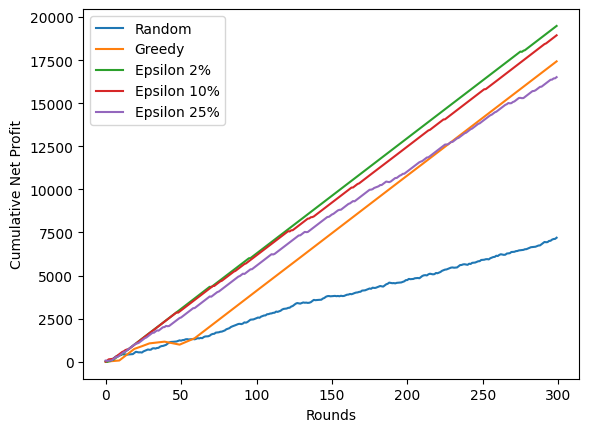

In [6]:

plt.figure()
plt.plot(random_rewards, label="Random")
plt.plot(greedy_rewards, label="Greedy")
plt.plot(eps_2, label="Epsilon 2%")
plt.plot(eps_10, label="Epsilon 10%")
plt.plot(eps_25, label="Epsilon 25%")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Net Profit")
plt.legend()
plt.show()


# Conclusion (0.5M)



In [7]:
# Plot the cumulative net profit curves for all strategies tested.
# Which strategy produced the highest long-term cumulative profit, and why?
# Which product consistently emerged as the most profitable choice?

#-----write your code below this line---------

# Identify final cumulative profits
final_profits = {
    "Random Policy": random_rewards[-1],
    "Greedy Policy": greedy_rewards[-1],
    "Epsilon-Greedy (2%)": eps_2[-1],
    "Epsilon-Greedy (10%)": eps_10[-1],
    "Epsilon-Greedy (25%)": eps_25[-1]
}

# Print final cumulative profits
print("Final Cumulative Net Profit for Each Strategy:\n")
for strategy, profit in final_profits.items():
    print(f"{strategy}: {profit:.2f}")

# Identify best strategy
best_strategy = max(final_profits, key=final_profits.get)
print(f"\nBest Performing Strategy: {best_strategy}")

# Identify most profitable product overall
avg_net_rewards = {
    f"Product {i}": df[f"netreward_{i}"].mean()
    for i in range(1, 7)
}

best_product = max(avg_net_rewards, key=avg_net_rewards.get)

print("\nAverage Net Reward per Product:")
for product, value in avg_net_rewards.items():
    print(f"{product}: {value:.2f}")

print(f"\nMost Profitable Product Overall: {best_product}")



Final Cumulative Net Profit for Each Strategy:

Random Policy: 7197.37
Greedy Policy: 17430.62
Epsilon-Greedy (2%): 19486.65
Epsilon-Greedy (10%): 18941.85
Epsilon-Greedy (25%): 16514.25

Best Performing Strategy: Epsilon-Greedy (2%)

Average Net Reward per Product:
Product 1: 7.06
Product 2: 66.99
Product 3: 31.42
Product 4: 9.60
Product 5: -17.06
Product 6: 36.99

Most Profitable Product Overall: Product 2
